# LSTM Model

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Directory for saving outputs
output_result = 'final_testing/lstm/single'

# Ensure directories exist
os.makedirs(output_result, exist_ok=True)

# Load and sort your data
df = pd.read_csv("7.7.2025.csv")
df["timestamp_sec"] = df["timestamp"] / 1000
df_sorted = df.sort_values(by="timestamp_sec").reset_index(drop=True)

# Denoise using moving average
df['x_snap'] = df['x_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
df['y_snap'] = df['y_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')

# Use x_snap and y_snap only
data = df_sorted[["x_snap", "y_snap"]].values

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_lstm_sequences(data, seq_length, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters
seq_length = 12
X, y = create_lstm_sequences(data_scaled, seq_length)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

# Early Stopping 
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Store RMSE values across runs
rmse_lstm_records = []

for run in range(10):
    print(f"\n--- LSTM Training Run {run + 1} ---")
    tf.random.set_seed(run)
    
    # Model
    model_lstm = Sequential([
        LSTM(128, return_sequences =True, activation='tanh', input_shape=(seq_length, 2)),
        LSTM(64, activation = 'tanh'),
        Dense(32, activation = 'relu'),
        Dense(2)
    ])
    optimizer = Adam(learning_rate = 1e-3)
    model_lstm.compile(optimizer=optimizer, loss='mse')

    # Train
    model_lstm.fit(
        X_train, y_train, 
        epochs=100, 
        batch_size=32, 
        validation_split=0.1, 
        verbose=0, 
        callbacks=[early_stop])

    # Predict
    y_pred = model_lstm.predict(X_test)
    y_test_lstm_inv = scaler.inverse_transform(y_test)
    y_pred_lstm_inv = scaler.inverse_transform(y_pred)

    # RMSE calculation
    rmse_x = np.sqrt(mean_squared_error(y_test_lstm_inv[:, 0], y_pred_lstm_inv[:, 0]))
    rmse_y = np.sqrt(mean_squared_error(y_test_lstm_inv[:, 1], y_pred_lstm_inv[:, 1]))
    rmse_xy = np.sqrt(np.mean(np.sum((y_test_lstm_inv - y_pred_lstm_inv) ** 2, axis=1)))

    print(f"Run {run+1} - RMSE(x): {rmse_x:.4f}, RMSE(y): {rmse_y:.4f}, Euclidean RMSE: {rmse_xy:.4f}")

    # Save RMSEs
    rmse_lstm_records.append({
        'run': run + 1,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'rmse_xy': rmse_xy
    })

# Save RMSE values to CSV
rmse_df = pd.DataFrame(rmse_lstm_records)
rmse_path = os.path.join(output_result, "lstm_rmse_10runs.csv")
rmse_df.to_csv(rmse_path, index=False)
print(f"\nSaved RMSE values to: {rmse_path}")

# Plot predicted vs true positions
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm_inv[:, 0], y_test_lstm_inv[:, 1], label='True (x, y)', alpha=0.6)
plt.plot(y_pred_lstm_inv[:, 0], y_pred_lstm_inv[:, 1], label='Predicted (x, y)', alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"LSTM Prediction (Euclidean RMSE = {rmse_xy:.2f})")
plt.savefig("final_testing/lstm/single/LSTM Prediction Euclidean Error.png")
plt.grid(True)
plt.axis('equal')
plt.show()

/var/folders/l_/y6_ywm857n388x9s5vgswchm0000gn/T/ipykernel_82247/3035085307.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['x_snap'] = df['x_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
/var/folders/l_/y6_ywm857n388x9s5vgswchm0000gn/T/ipykernel_82247/3035085307.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y_snap'] = df['y_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X_train.shape: (325, 20, 2)
X_test.shape: (82, 20, 2)

--- LSTM Training Run 1 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Run 1 - RMSE(x): 2.5945, RMSE(y): 2.3082, Euclidean RMSE: 3.4726

--- LSTM Training Run 2 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Run 2 - RMSE(x): 2.2437, RMSE(y): 2.3322, Euclidean RMSE: 3.2362

--- LSTM Training Run 3 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x30dee1750> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Run 3 - RMSE(x): 2.3911, RMSE(y): 2.4888, Euclidean RMSE: 3.4513

--- LSTM Training Run 4 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Run 4 - RMSE(x): 2.6482, RMSE(y): 2.3624, Euclidean RMSE: 3.5488

--- LSTM Training Run 5 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Run 5 - RMSE(x): 2.7751, RMSE(y): 2.5390, Euclidean RMSE: 3.7613

--- LSTM Training Run 6 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Random Forest Method

X_train.shape: (333, 20)
X_test.shape: (84, 20)
[Run 1] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 2] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 3] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 4] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 5] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 6] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 7] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 8] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 9] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
[Run 10] RMSE (x): 1.7671, RMSE (y): 1.5887, Euclidean RMSE: 2.3762
Saved RMSE values to final_testing/rf/rf_rmse_10runs.csv


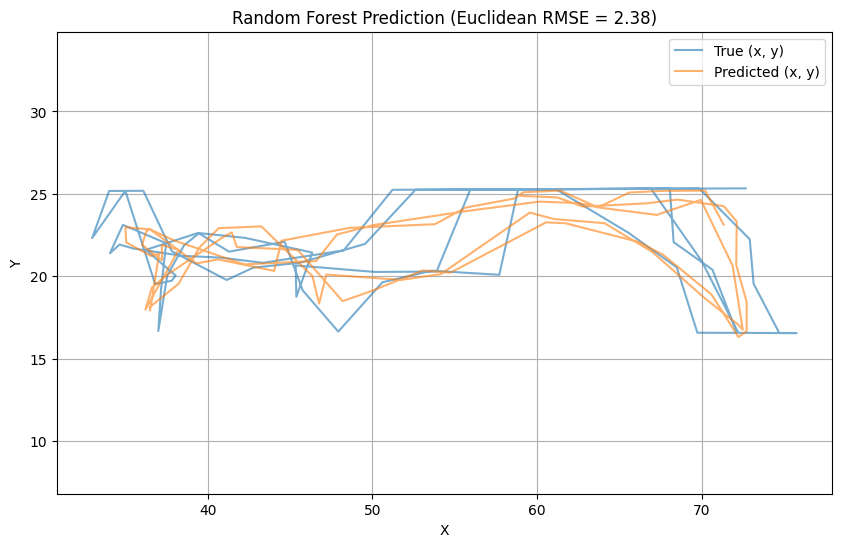

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Directory for saving outputs
output_result = 'final_testing/rf'

# Ensure directories exist
os.makedirs(output_result, exist_ok=True)

# Load and sort data
df = pd.read_csv("7.7.2025.csv")
df["timestamp_sec"] = df["timestamp"] / 1000
df_sorted = df.sort_values(by="timestamp_sec").reset_index(drop=True)

# Use x_snap and y_snap only
data = df_sorted[["x_snap", "y_snap"]].values

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for Random Forest (flattened input)
def create_rf_sequences(data, seq_length, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        seq = data[i:i+seq_length].flatten()  # Flatten for RandomForest
        target = data[i+seq_length]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# Parameters 
seq_length = 10
X, y = create_rf_sequences(data_scaled, seq_length)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

# Store RMSE values across runs
rmse_rf_records = []

for run in range(10):
    # Train Random Forest model
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)

    # Predict
    y_pred = model_rf.predict(X_test)

    # Inverse scale to get original coordinates
    y_test_rf_inv = scaler.inverse_transform(y_test)
    y_pred_rf_inv = scaler.inverse_transform(y_pred)

    # === Compute RMSE ===
    rmse_x = np.sqrt(mean_squared_error(y_test_rf_inv[:, 0], y_pred_rf_inv[:, 0]))
    rmse_y = np.sqrt(mean_squared_error(y_test_rf_inv[:, 1], y_pred_rf_inv[:, 1]))

    # Euclidean RMSE
    rmse_xy = np.sqrt(np.mean(np.sum((y_test_rf_inv - y_pred_rf_inv) ** 2, axis=1)))

    print(f"[Run {run+1}] RMSE (x): {rmse_x:.4f}, RMSE (y): {rmse_y:.4f}, Euclidean RMSE: {rmse_xy:.4f}")

    # Save RMSEs for this run
    rmse_rf_records.append({
        'run': run + 1,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'rmse_xy': rmse_xy
    })

# Save all RMSEs to CSV
rmse_df = pd.DataFrame(rmse_rf_records)
rmse_df.to_csv(os.path.join(output_result, "rf_rmse_10runs.csv"), index=False)
print(f"Saved RMSE values to {output_result}/rf_rmse_10runs.csv")

# Plot predicted vs true positions
plt.figure(figsize=(10, 6))
plt.plot(y_test_rf_inv[:, 0], y_test_rf_inv[:, 1], label='True (x, y)', alpha=0.6)
plt.plot(y_pred_rf_inv[:, 0], y_pred_rf_inv[:, 1], label='Predicted (x, y)', alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"Random Forest Prediction (Euclidean RMSE = {rmse_xy:.2f})")
plt.savefig("final_testing/rf/Random Forest Prediction Euclidean RMSE.png")
plt.grid(True)
plt.axis('equal')
plt.show()

# XGBoost Method

[Run 1] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 2] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 3] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 4] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 5] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 6] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 7] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 8] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 9] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
[Run 10] RMSE (x): 1.9188, RMSE (y): 1.6368, Euclidean RMSE: 2.5221
Saved RMSE values to final_testing/xgb/xgb_rmse_10runs.csv


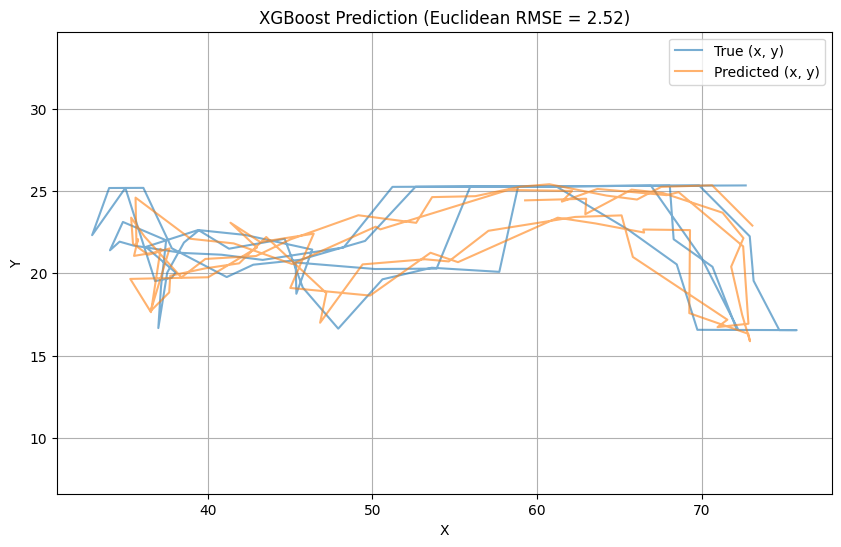

In [13]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Directory for saving outputs
output_result = 'final_testing/xgb'

# Ensure directories exist
os.makedirs(output_result, exist_ok=True)

# Load and sort data
df = pd.read_csv("7.7.2025.csv")
df["timestamp_sec"] = df["timestamp"] / 1000
df_sorted = df.sort_values(by="timestamp_sec").reset_index(drop=True)

# Use x_snap and y_snap only
data = df_sorted[["x_snap", "y_snap"]].values

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_xgb_sequences(data, seq_length, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i+seq_length].flatten())
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters
seq_length = 10
X, y = create_xgb_sequences(data_scaled, seq_length)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Store RMSE values across runs
rmse_xgb_records = []

for run in range(10):
    # Train XGBoost model (2 outputs: x and y)
    model_xgb = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
    model_xgb.fit(X_train, y_train)

    # Predict
    y_pred = model_xgb.predict(X_test)

    # Inverse transform
    y_test_xgb_inv = scaler.inverse_transform(y_test)
    y_pred_xgb_inv = scaler.inverse_transform(y_pred)

    # Errors
    rmse_x = np.sqrt(mean_squared_error(y_test_xgb_inv[:, 0], y_pred_xgb_inv[:, 0]))
    rmse_y = np.sqrt(mean_squared_error(y_test_xgb_inv[:, 1], y_pred_xgb_inv[:, 1]))
    rmse_xy = np.sqrt(np.mean(np.sum((y_test_xgb_inv - y_pred_xgb_inv) ** 2, axis=1)))

    print(f"[Run {run+1}] RMSE (x): {rmse_x:.4f}, RMSE (y): {rmse_y:.4f}, Euclidean RMSE: {rmse_xy:.4f}")

    # Save RMSEs for this run
    rmse_xgb_records.append({
        'run': run + 1,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'rmse_xy': rmse_xy
    })

# Save all RMSEs to CSV
rmse_df = pd.DataFrame(rmse_xgb_records)
rmse_df.to_csv(os.path.join(output_result, "xgb_rmse_10runs.csv"), index=False)
print(f"Saved RMSE values to {output_result}/xgb_rmse_10runs.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_xgb_inv[:, 0], y_test_xgb_inv[:, 1], label='True (x, y)', alpha=0.6)
plt.plot(y_pred_xgb_inv[:, 0], y_pred_xgb_inv[:, 1], label='Predicted (x, y)', alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"XGBoost Prediction (Euclidean RMSE = {rmse_xy:.2f})")
plt.savefig("final_testing/xgb/XGBoost Prediction Euclidean RMSE.png")
plt.grid(True)
plt.axis('equal')
plt.show()

# LightGBM Method

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 333, number of used features: 20
[LightGBM] [Info] Start training from score 0.465530
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Run 1] RMSE (x): 1.6444, RMSE (y): 1.6011, Euclidean RMSE: 2.2951
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 333, number of used features: 20
[LightGBM] [Info] Start training from score 0.465530
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Run 3] RMSE (x): 1.6444, RMSE (y): 1.6011, Euclidean RMSE: 2.2951
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 333, number of used features: 20
[LightGBM] [Info] Start training from score 0.465530
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 333, number of used features: 20
[LightGBM] [Info] Start training from score 0.654895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


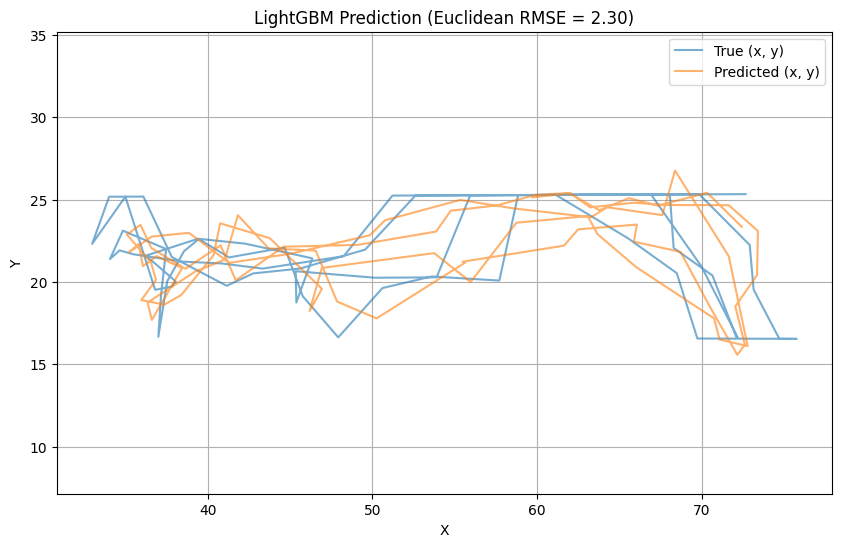

In [14]:
import os
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

# Directory for saving outputs
output_result = 'final_testing/lightgbm'

# Ensure directories exist
os.makedirs(output_result, exist_ok=True)

# Load and sort data
df = pd.read_csv("7.7.2025.csv")
df["timestamp_sec"] = df["timestamp"] / 1000
df_sorted = df.sort_values(by="timestamp_sec").reset_index(drop=True)

# Use x_snap and y_snap only
data = df_sorted[["x_snap", "y_snap"]].values

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_lightgbm_sequences(data, seq_length, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i+seq_length].flatten())
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters
seq_length = 10
X, y = create_lightgbm_sequences(data_scaled, seq_length)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Store RMSE values across runs
rmse_lgbm_records = []

for run in range(10):
    # Train LightGBM model
    model_lightgbm = MultiOutputRegressor(LGBMRegressor(n_estimators=100, random_state=42))
    model_lightgbm.fit(X_train, y_train)

    # Predict
    y_pred = model_lightgbm.predict(X_test)

    # Inverse transform
    y_test_lightgbm_inv = scaler.inverse_transform(y_test)
    y_pred_lightgbm_inv = scaler.inverse_transform(y_pred)

    # Errors
    rmse_x = np.sqrt(mean_squared_error(y_test_lightgbm_inv[:, 0], y_pred_lightgbm_inv[:, 0]))
    rmse_y = np.sqrt(mean_squared_error(y_test_lightgbm_inv[:, 1], y_pred_lightgbm_inv[:, 1]))
    rmse_xy = np.sqrt(np.mean(np.sum((y_test_lightgbm_inv - y_pred_lightgbm_inv) ** 2, axis=1)))

    print(f"[Run {run+1}] RMSE (x): {rmse_x:.4f}, RMSE (y): {rmse_y:.4f}, Euclidean RMSE: {rmse_xy:.4f}")

    # Save RMSEs for this run
    rmse_lgbm_records.append({
        'run': run + 1,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'rmse_xy': rmse_xy
    })

# Save all RMSEs to CSV
rmse_df = pd.DataFrame(rmse_lgbm_records)
rmse_df.to_csv(os.path.join(output_result, "lgbm_rmse_10runs.csv"), index=False)
print(f"Saved RMSE values to {output_result}/lgbm_rmse_10runs.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_lightgbm_inv[:, 0], y_test_lightgbm_inv[:, 1], label='True (x, y)', alpha=0.6)
plt.plot(y_pred_lightgbm_inv[:, 0], y_pred_lightgbm_inv[:, 1], label='Predicted (x, y)', alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"LightGBM Prediction (Euclidean RMSE = {rmse_xy:.2f})")
plt.savefig("final_testing/lightgbm/LightGBM Prediction Euclidean RMSE.png")
plt.grid(True)
plt.axis('equal')
plt.show()

# Gradient Boosting Method

[Run 1] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 2] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 3] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 4] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 5] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 6] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 7] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 8] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 9] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
[Run 10] RMSE (x): 1.5818, RMSE (y): 1.6298, Euclidean RMSE: 2.2712
Saved RMSE values to final_testing/gb/gb_rmse_10runs.csv


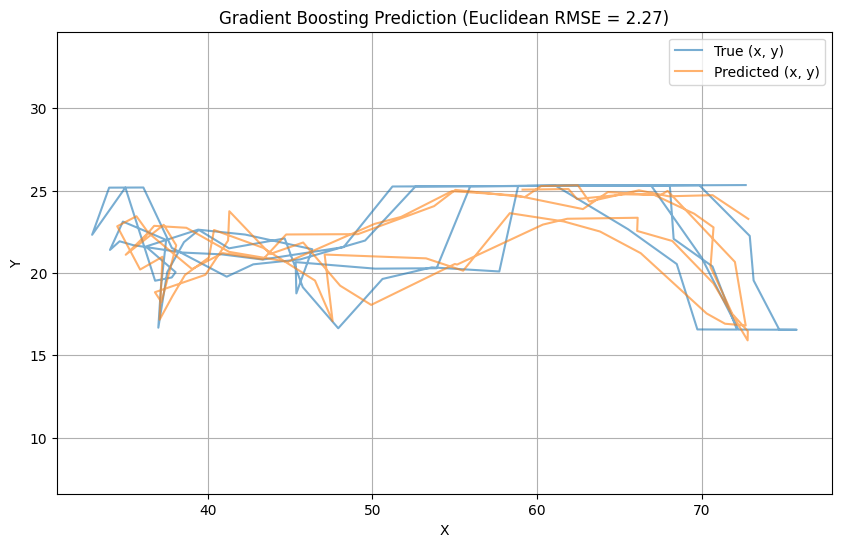

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

# Directory for saving outputs
output_result = 'final_testing/gb'

# Ensure directories exist
os.makedirs(output_result, exist_ok=True)

# Load and preprocess
df = pd.read_csv("7.7.2025.csv")
df["timestamp_sec"] = df["timestamp"] / 1000
df_sorted = df.sort_values(by="timestamp_sec").reset_index(drop=True)
data = df_sorted[["x_snap", "y_snap"]].values

# Normalize 
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Sequence creation
def create_gb_sequences(data, seq_length, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i+seq_length].flatten())
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters
seq_length = 10
X, y = create_gb_sequences(data_scaled, seq_length)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Store RMSE values across runs 
rmse_gb_records = []

for run in range(10):
    # Gradient Boosting (sklearn)
    model_gb = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))
    model_gb.fit(X_train, y_train)

    y_pred = model_gb.predict(X_test)
    y_test_gb_inv = scaler.inverse_transform(y_test)
    y_pred_gb_inv = scaler.inverse_transform(y_pred)

    # RMSE calculation
    rmse_x = np.sqrt(mean_squared_error(y_test_gb_inv[:, 0], y_pred_gb_inv[:, 0]))
    rmse_y = np.sqrt(mean_squared_error(y_test_gb_inv[:, 1], y_pred_gb_inv[:, 1]))
    rmse_xy = np.sqrt(np.mean(np.sum((y_test_gb_inv - y_pred_gb_inv) ** 2, axis=1)))

    print(f"[Run {run+1}] RMSE (x): {rmse_x:.4f}, RMSE (y): {rmse_y:.4f}, Euclidean RMSE: {rmse_xy:.4f}")

    # Save RMSEs for this run
    rmse_gb_records.append({
        'run': run + 1,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'rmse_xy': rmse_xy
    })

# Save all RMSEs to CSV
rmse_df = pd.DataFrame(rmse_gb_records)
rmse_df.to_csv(os.path.join(output_result, "gb_rmse_10runs.csv"), index=False)
print(f"Saved RMSE values to {output_result}/gb_rmse_10runs.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_gb_inv[:, 0], y_test_gb_inv[:, 1], label='True (x, y)', alpha=0.6)
plt.plot(y_pred_gb_inv[:, 0], y_pred_gb_inv[:, 1], label='Predicted (x, y)', alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"Gradient Boosting Prediction (Euclidean RMSE = {rmse_xy:.2f})")
plt.savefig("final_testing/gb/Gradient Boosting Prediction Euclidean RMSE.png")
plt.grid(True)
plt.axis('equal')
plt.show()

# CatBoost Regressor Method

[Run 1] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 2] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 3] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 4] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 5] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 6] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 7] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 8] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 9] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
[Run 10] RMSE (x): 1.7408, RMSE (y): 1.5624, Euclidean RMSE: 2.3391
Saved RMSE values to final_testing/cb/cb_rmse_10runs.csv


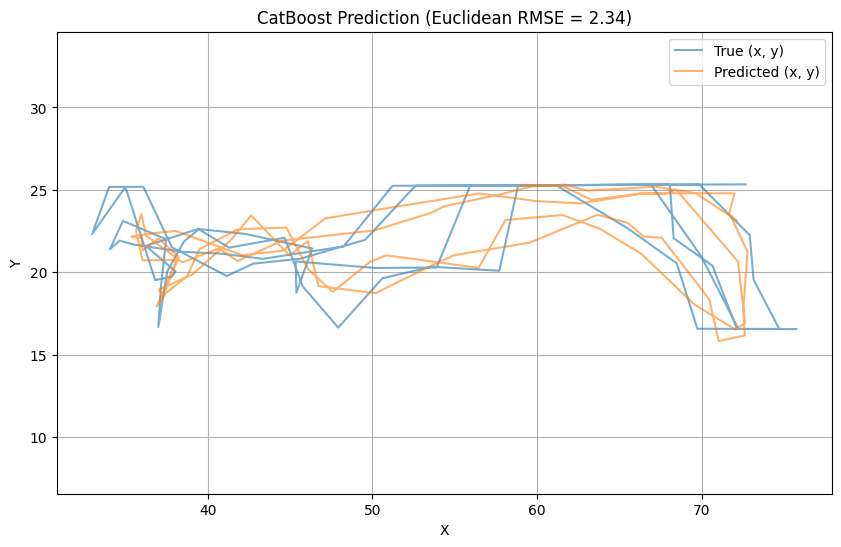

In [16]:
import os 
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

# Directory for saving outputs
output_result = 'final_testing/cb'

# Ensure directories exist
os.makedirs(output_result, exist_ok=True)

# Load and preprocess
df = pd.read_csv("7.7.2025.csv")
df["timestamp_sec"] = df["timestamp"] / 1000
df_sorted = df.sort_values(by="timestamp_sec").reset_index(drop=True)
data = df_sorted[["x_snap", "y_snap"]].values

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Sequence creation
def create_cb_sequences(data, seq_length, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i+seq_length].flatten())
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters
seq_length = 10
X, y = create_cb_sequences(data_scaled, seq_length)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Store RMSE values across runs
rmse_cb_records = []

for run in range(10):
    # CatBoost model
    model_cb = MultiOutputRegressor(CatBoostRegressor(iterations=100, learning_rate=0.1, verbose=0, random_seed=42))
    model_cb.fit(X_train, y_train)

    y_pred = model_cb.predict(X_test)
    y_test_cb_inv = scaler.inverse_transform(y_test)
    y_pred_cb_inv = scaler.inverse_transform(y_pred)

    # RMSE
    rmse_x = np.sqrt(mean_squared_error(y_test_cb_inv[:, 0], y_pred_cb_inv[:, 0]))
    rmse_y = np.sqrt(mean_squared_error(y_test_cb_inv[:, 1], y_pred_cb_inv[:, 1]))
    rmse_xy = np.sqrt(np.mean(np.sum((y_test_cb_inv - y_pred_cb_inv) ** 2, axis=1)))

    print(f"[Run {run+1}] RMSE (x): {rmse_x:.4f}, RMSE (y): {rmse_y:.4f}, Euclidean RMSE: {rmse_xy:.4f}")

    # Save RMSEs for this run
    rmse_cb_records.append({
        'run': run + 1,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'rmse_xy': rmse_xy
    })

# Save all RMSEs to CSV
rmse_df = pd.DataFrame(rmse_cb_records)
rmse_df.to_csv(os.path.join(output_result, "cb_rmse_10runs.csv"), index=False)
print(f"Saved RMSE values to {output_result}/cb_rmse_10runs.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_cb_inv[:, 0], y_test_cb_inv[:, 1], label='True (x, y)', alpha=0.6)
plt.plot(y_pred_cb_inv[:, 0], y_pred_cb_inv[:, 1], label='Predicted (x, y)', alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"CatBoost Prediction (Euclidean RMSE = {rmse_xy:.2f})")
plt.savefig("final_testing/cb/CatBoost Prediction Euclidean RMSE.png")
plt.grid(True)
plt.axis('equal')
plt.show()

# Compare all Models (Single Boxplot of RMSE XY)

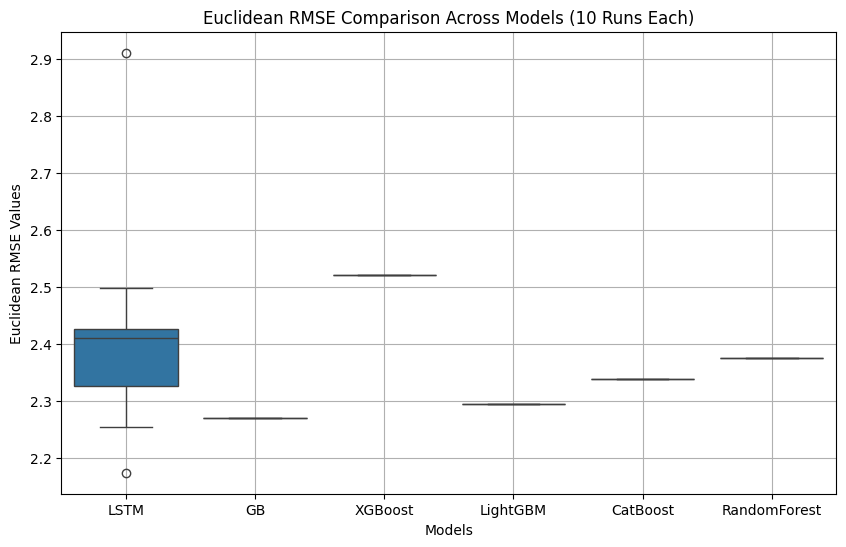

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define model names and paths
models = {
    "LSTM": "final_testing/lstm/single/lstm_rmse_10runs.csv",
    "GB": "final_testing/gb/gb_rmse_10runs.csv",
    "XGBoost": "final_testing/xgb/xgb_rmse_10runs.csv",
    "LightGBM": "final_testing/lightgbm/lgbm_rmse_10runs.csv",
    "CatBoost": "final_testing/cb/cb_rmse_10runs.csv",
    "RandomForest": "final_testing/rf/rf_rmse_10runs.csv"
}

# Load and concatenate
all_data = []

for model_name, path in models.items():
    df = pd.read_csv(path)
    df["model"] = model_name
    all_data.append(df[["rmse_xy", "model"]])

df_all = pd.concat(all_data, ignore_index=True)

# === Plot Boxplot ===
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x="model", y="rmse_xy")
plt.title("Euclidean RMSE Comparison Across Models (10 Runs Each)")
plt.ylabel("Euclidean RMSE Values")
plt.xlabel("Models")
plt.grid(True)
plt.savefig("final_testing/rmse_comparison_boxplot.png")
plt.show()

# Evaluation Metrics

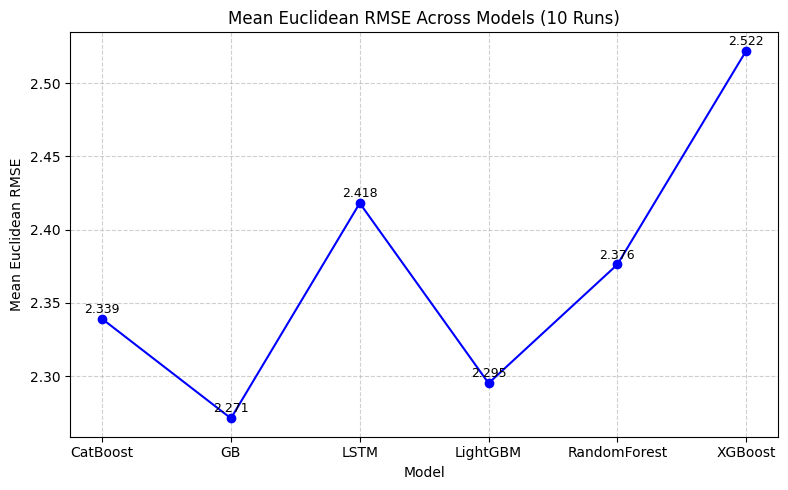

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model names and paths again
models = {
    "LSTM": "final_testing/lstm/single/lstm_rmse_10runs.csv",
    "GB": "final_testing/gb/gb_rmse_10runs.csv",
    "XGBoost": "final_testing/xgb/xgb_rmse_10runs.csv",
    "LightGBM": "final_testing/lightgbm/lgbm_rmse_10runs.csv",
    "CatBoost": "final_testing/cb/cb_rmse_10runs.csv",
    "RandomForest": "final_testing/rf/rf_rmse_10runs.csv"
}

# Compute mean rmse_xy for each model
mean_rmse = {}
for model_name, path in models.items():
    df = pd.read_csv(path)
    mean_rmse[model_name] = df["rmse_xy"].mean()

# Convert to DataFrame for plotting
mean_df = pd.DataFrame(list(mean_rmse.items()), columns=["Model", "Mean_RMSE"])
mean_df = mean_df.sort_values("Model")  # Sort alphabetically or however you'd like

# Plot line chart
plt.figure(figsize=(8, 5))
plt.plot(mean_df["Model"], mean_df["Mean_RMSE"], marker='o', linestyle='-', color='blue')
for i, val in enumerate(mean_df["Mean_RMSE"]):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

plt.title("Mean Euclidean RMSE Across Models (10 Runs)")
plt.xlabel("Model")
plt.ylabel("Mean Euclidean RMSE")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("final_testing/mean_rmse_line_chart.png")
plt.show()


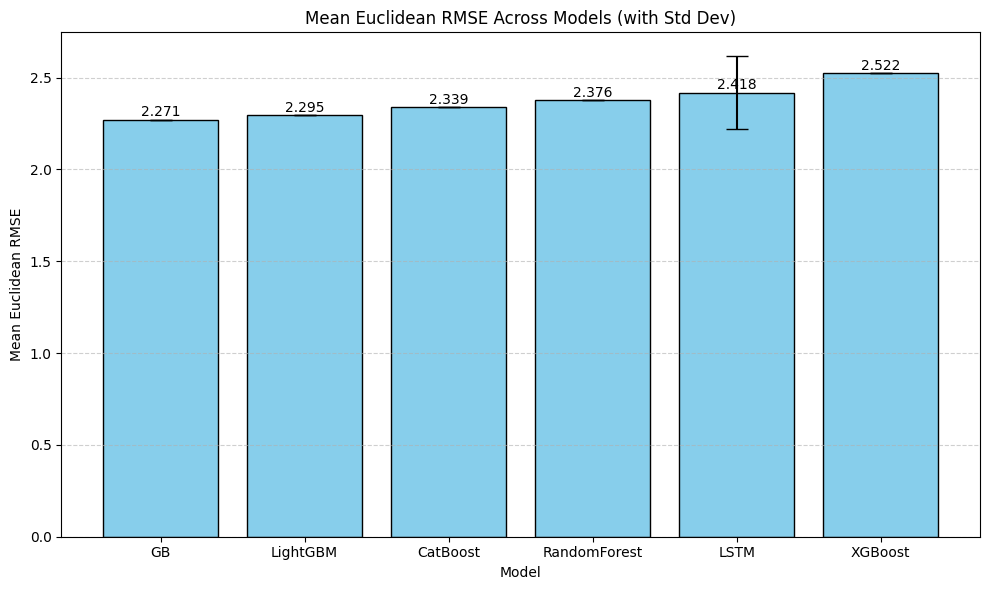

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model names and paths
models = {
    "LSTM": "final_testing/lstm/single/lstm_rmse_10runs.csv",
    "GB": "final_testing/gb/gb_rmse_10runs.csv",
    "XGBoost": "final_testing/xgb/xgb_rmse_10runs.csv",
    "LightGBM": "final_testing/lightgbm/lgbm_rmse_10runs.csv",
    "CatBoost": "final_testing/cb/cb_rmse_10runs.csv",
    "RandomForest": "final_testing/rf/rf_rmse_10runs.csv"
}

# Compute mean and std for rmse_xy
rmse_stats = []

for model_name, path in models.items():
    df = pd.read_csv(path)
    mean_rmse = df["rmse_xy"].mean()
    std_rmse = df["rmse_xy"].std()
    rmse_stats.append({
        "Model": model_name,
        "Mean_RMSE": mean_rmse,
        "Std_RMSE": std_rmse
    })

# Create DataFrame
rmse_df = pd.DataFrame(rmse_stats)

# Sort by mean RMSE (ascending)
rmse_df = rmse_df.sort_values("Mean_RMSE")

# Plot bar chart with error bars
plt.figure(figsize=(10, 6))
bars = plt.bar(
    rmse_df["Model"], 
    rmse_df["Mean_RMSE"], 
    yerr=rmse_df["Std_RMSE"], 
    capsize=8,
    color='skyblue',
    edgecolor='black'
)

# Annotate each bar with mean RMSE
for bar, mean in zip(bars, rmse_df["Mean_RMSE"]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{mean:.3f}", ha='center', va='bottom', fontsize=10)

plt.title("Mean Euclidean RMSE Across Models (with Std Dev)")
plt.ylabel("Mean Euclidean RMSE")
plt.xlabel("Model")
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.tight_layout()
plt.savefig("final_testing/mean_rmse_sorted_bar_chart.png")
plt.show()


/var/folders/l_/y6_ywm857n388x9s5vgswchm0000gn/T/ipykernel_75265/3309442882.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['x_snap'] = df['x_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
/var/folders/l_/y6_ywm857n388x9s5vgswchm0000gn/T/ipykernel_75265/3309442882.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y_snap'] = df['y_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X_train.shape: (166, 12, 2)
X_test.shape: (42, 12, 2)

--- Optimized LSTM Training Run 1 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Run 1 - RMSE(x): 1.5864, RMSE(y): 0.7700, Euclidean RMSE: 1.7634

--- Optimized LSTM Training Run 2 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Run 2 - RMSE(x): 1.5699, RMSE(y): 0.7166, Euclidean RMSE: 1.7257

--- Optimized LSTM Training Run 3 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Run 3 - RMSE(x): 1.6567, RMSE(y): 1.0918, Euclidean RMSE: 1.9841

--- Optimized LSTM Training Run 4 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Run 4 - RMSE(x): 1.5307, RMSE(y): 0.9434, Euclidean RMSE: 1.7981

--- Optimized LSTM Training Run 5 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Run 5 - RMSE(x): 1.3463, RMSE(y): 0.7447, Euclidean RMSE: 1.5385

--- Optimized LSTM Training Run 6 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Run 6 - RMSE(x): 1.4783, RMSE(y): 0.7299, Euclidean RMSE: 1.6487

--- Optimized LSTM Training Run 7 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Run 7 - RMSE(x): 1.5856, RMSE(y): 0.7209, Euclidean RMSE: 1.7418

--- Optimized LSTM Training Run 8 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Run 8 - RMSE(x): 1.3875, RMSE(y): 0.6674, Euclidean RMSE: 1.5397

--- Optimized LSTM Training Run 9 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Run 9 - RMSE(x): 1.2862, RMSE(y): 0.5991, Euclidean RMSE: 1.4189

--- Optimized LSTM Training Run 10 ---


/Users/hoihpi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Run 10 - RMSE(x): 1.7166, RMSE(y): 0.7049, Euclidean RMSE: 1.8557

✅ Saved RMSE values to: final_testing/lstm/optimized/lstm_rmse_10runs.csv


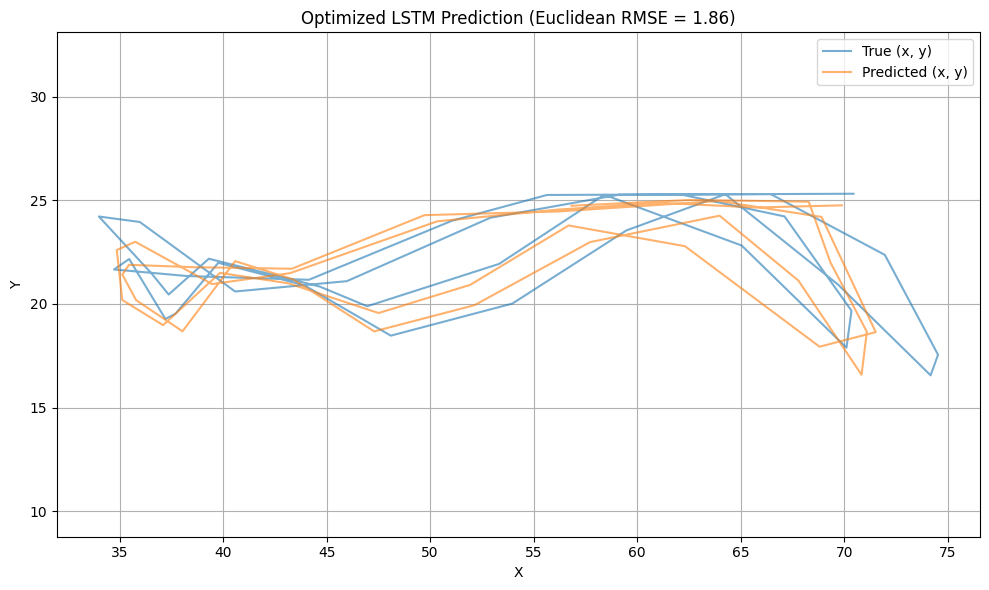

In [25]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Directory for saving outputs ===
output_result = 'final_testing/lstm/optimized'
os.makedirs(output_result, exist_ok=True)

# === Load and sort your data ===
df = pd.read_csv("7.7.2025.csv")
df["timestamp_sec"] = df["timestamp"] / 1000
df = df.sort_values(by="timestamp_sec").reset_index(drop=True)

# === Optional: Denoise using moving average ===
df['x_snap'] = df['x_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
df['y_snap'] = df['y_snap'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')

# === Use only x_snap and y_snap
data = df[["x_snap", "y_snap"]].values

# === Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# === Sequence generator
def create_lstm_sequences(data, seq_length, stride=2):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# === Parameters
seq_length = 12  # Longer sequence
X, y = create_lstm_sequences(data_scaled, seq_length)

# === Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

# === Early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

# === Store RMSE values across runs
rmse_lstm_records = []

for run in range(10):
    print(f"\n--- Optimized LSTM Training Run {run + 1} ---")
    tf.random.set_seed(run)

    # Model
    model_lstm = Sequential([
        LSTM(128, return_sequences=True, activation='tanh', input_shape=(seq_length, 2)),
        LSTM(64, activation='tanh'),
        Dense(32, activation='relu'),
        Dense(2)
    ])
    optimizer = Adam(learning_rate=1e-3)  # Lower LR for stable training
    model_lstm.compile(optimizer=optimizer, loss='mse')

    # Train
    model_lstm.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[early_stop]
    )

    # Predict
    y_pred = model_lstm.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)

    # RMSE calculation
    rmse_x = np.sqrt(mean_squared_error(y_test_inv[:, 0], y_pred_inv[:, 0]))
    rmse_y = np.sqrt(mean_squared_error(y_test_inv[:, 1], y_pred_inv[:, 1]))
    rmse_xy = np.sqrt(np.mean(np.sum((y_test_inv - y_pred_inv) ** 2, axis=1)))

    print(f"Run {run+1} - RMSE(x): {rmse_x:.4f}, RMSE(y): {rmse_y:.4f}, Euclidean RMSE: {rmse_xy:.4f}")

    # Save RMSEs
    rmse_lstm_records.append({
        'run': run + 1,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'rmse_xy': rmse_xy
    })

# === Save RMSE values to CSV
rmse_df = pd.DataFrame(rmse_lstm_records)
rmse_path = os.path.join(output_result, "lstm_rmse_10runs.csv")
rmse_df.to_csv(rmse_path, index=False)
print(f"\n✅ Saved RMSE values to: {rmse_path}")

# === Plot predicted vs true positions from the last run
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:, 0], y_test_inv[:, 1], label='True (x, y)', alpha=0.6)
plt.plot(y_pred_inv[:, 0], y_pred_inv[:, 1], label='Predicted (x, y)', alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"Optimized LSTM Prediction (Euclidean RMSE = {rmse_xy:.2f})")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join(output_result, "LSTM_Prediction_Euclidean_Error.png"))
plt.show()